# Example :  HMM of Financial Time Series using hmmlearn

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from hmmlearn import hmm
import math
import os

import datetime
import warnings

from numpy.lib.stride_tricks import as_strided
import scipy
from scipy.io import wavfile
from sklearn.model_selection import StratifiedShuffleSplit
import mpl_finance
import itertools

from matplotlib import cm, pyplot as plt

from matplotlib.dates import YearLocator, MonthLocator

from mpl_finance import candlestick_ohlc
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm


### Set Variables

In [2]:
test_size=0.33
n_latency_days=10
n_hidden_states=4
n_steps_frac_change=50
n_steps_frac_high=10
n_steps_frac_low=10

### Import Data

In [3]:
data = pd.read_csv('INTC_data.csv')

In [4]:
train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)

### Calculate outcomes from selected features

In [5]:
def extract_features(data):
        open_price = np.array(data['Open'])
        close_price = np.array(data['Close'])
        high_price = np.array(data['High'])
        low_price = np.array(data['Low'])
        # Compute the fraction change in close, high and low prices which would be used as features
        frac_change = (close_price - open_price) / open_price
        frac_high = (high_price - open_price) / open_price
        frac_low = (open_price - low_price) / open_price
        
        return np.column_stack((frac_change, frac_high, frac_low))

In [6]:
train_features = extract_features(train_data)

In [7]:
def compute_all_possible_outcomes(n_steps_frac_change, n_steps_frac_high, n_steps_frac_low):
        frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
        frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
        frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)
        #Itertools takes any number of iterables as arguments and returns an iterator over tuples in the Cartesian product
        possible_outcomes = np.array(list(itertools.product(frac_change_range, frac_high_range, frac_low_range)))
       
        return possible_outcomes

### Calculate most probable outcome from HMM score

In [8]:
def get_most_probable_outcome(day_index, possible_outcomes):
        previous_data_start_index = max(0, day_index - n_latency_days)
        previous_data_end_index = max(0, day_index - 1)
        previous_data = test_data.iloc[previous_data_end_index: previous_data_start_index]
        previous_data_features = extract_features(previous_data)
        outcome_score = []
        most_probable_outcome =[]
        for possible_outcome in possible_outcomes:
            total_data = np.row_stack((previous_data_features, possible_outcome))
            outcome_score.append(intc_hmm.score(total_data))
        maxscore_index = np.argmax(outcome_score)
        most_probable_outcome = possible_outcomes[maxscore_index]
        #print(most_probable_outcome,maxscore_index )
        return most_probable_outcome


### Predict prices from the most probable outcome

In [9]:
def predict_close_price(day_index):
        open_price = test_data.iloc[day_index]['Open']
        predicted_frac_change= get_most_probable_outcome(day_index, possible_outcomes)
        #print(predicted_frac_change)
        close_price_predict = (open_price * (1 + predicted_frac_change))
        return close_price_predict
 

In [10]:
def predict_close_prices_for_days(test_data, possible_outcomes, days, with_plot=True):
        predicted_close_prices = []
        for day_index in tqdm(range(days)):
            cpp = predict_close_price(day_index)
            #print(cpp)
            predicted_close_prices.append(predict_close_price(day_index))
            #print(day_index, predicted_close_prices)
        predicted_close_prices=np.asarray(predicted_close_prices)
        #print(predicted_close_prices.shape)
        
        if with_plot:
            test_data = test_data[0: days]
            days = np.array(test_data['Date'], dtype="datetime64[ms]")
            actual_close_prices = test_data['Close']

            #fig = plt.figure()
            fig, ax = plt.subplots(figsize=(20,5))

            plt.plot(days, actual_close_prices, 'ro-', label="actual")
            #plt.plot(days, predicted_close_prices[:,0], 'g+-', label="predicted low", linewidth=1)
            #plt.plot(days, predicted_close_prices[:,2], 'y+-', label="predicted high", linewidth=1)
            plt.plot(days, predicted_close_prices[:,1], 'b+-', label="predicted", linewidth=1)
            plt.grid()
            plt.title('INTC Stock Movement',weight='bold', size=16)
            plt.xticks(rotation=90, size=10, weight='bold')
            plt.xlabel('Date',labelpad=10, weight='bold',size=12)
            plt.ylabel('Stock Price', labelpad=20, weight='bold', size=12)
            plt.legend()
            plt.show()

        #return predicted_close_prices

### Train a HMM to compute the parameters from a given sequence of observations.

In [12]:
intc_hmm =  hmm.GaussianHMM(n_components=n_hidden_states)

In [13]:
intc_hmm.fit(train_features)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=4, n_iter=10, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

### Execute functions and plot Predicted vs Actual

100%|██████████| 100/100 [03:44<00:00,  2.31s/it]


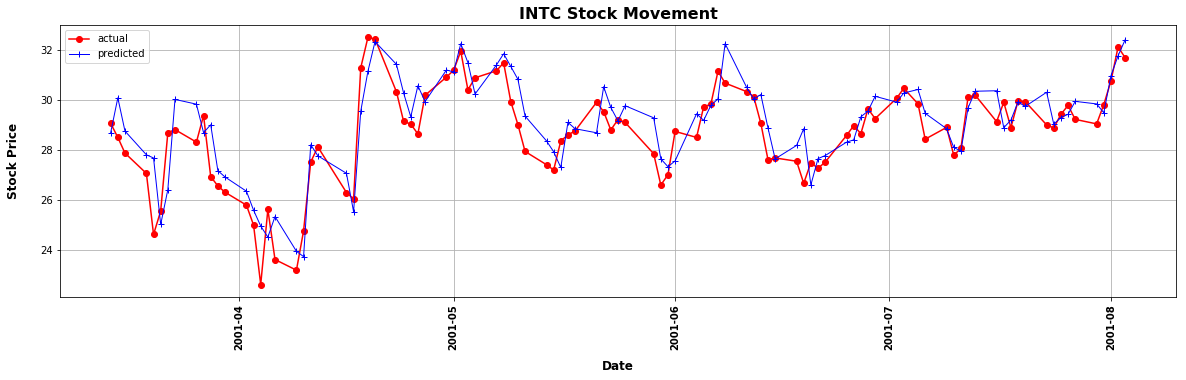

In [14]:
possible_outcomes = compute_all_possible_outcomes(n_steps_frac_change,n_steps_frac_high, n_steps_frac_low)
predict_close_prices_for_days(test_data, possible_outcomes,100, with_plot=True)